In [1]:
adfile_path = r"C:\Users\21lyb\Downloads\PBMC_simulated_cnas_041025.h5ad"

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
from biomart import BiomartServer
from io import StringIO
import anndata as ad
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

c:\Users\21lyb\Documents\CSCB-2025-Final\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Package,Version
numpy,1.26.4
pandas,2.2.3
scanpy,1.11.1
infercnvpy,0.6.0
matplotlib,3.10.0
biomart,0.9.2
anndata,0.11.4
Component,Info
Python,"3.11.6 | packaged by conda-forge | (main, Oct 3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]"
OS,Windows-10-10.0.26100-SP0


In [3]:
# Functions
def fetch_positions(adata):
    # Connect to Ensembl Biomart server
    server = BiomartServer("http://grch37.ensembl.org/biomart")
    dataset = server.datasets['hsapiens_gene_ensembl']

    # Query gene names for only missing gene positions
    no_positions = adata[:, adata.var[['start', 'end']].isna().any(axis=1)]
    with_positions = adata[:, ~adata.var[['start', 'end']].isna().any(axis=1)]
    response = dataset.search({
        'filters':{'ensembl_gene_id':list(no_positions.var['gene_ids'])},
        'attributes':['ensembl_gene_id','chromosome_name','start_position','end_position','strand']
    })

    # Convert response to DataFrame and merge with adata.var if response is successful
    if response.status_code == 200:
        print("Request successful!")
        gene_annotations_df = pd.read_csv(StringIO(response.text),sep='\t',header=None)
        gene_annotations_df.columns = ['gene_ids','chromosome','start','end','strand']
    else:
        print(f"Request failed with status code: {response.status_code}")
        print(response.text)

    # Isolate fetched genes from BioMart in no_positions adata
    fetched_positions = no_positions[:, no_positions.var['gene_ids'].isin(gene_annotations_df['gene_ids'])].copy()

    # Sort fetched genes based on ensembl gene IDs
    fetched_positions = fetched_positions[:, fetched_positions.var['gene_ids'].argsort()].copy()

    # Add the fetched gene positions to the adata
    fetched_positions.var['chromosome'] = gene_annotations_df['chromosome'].values
    fetched_positions.var['start'] = gene_annotations_df['start'].values
    fetched_positions.var['end'] = gene_annotations_df['end'].values
    fetched_positions.var['strand'] = gene_annotations_df['strand'].values

    # Concatenate fetched genes with isolated genes already with positions
    adClean = ad.concat([with_positions, fetched_positions], axis=1)

    # Include obs into the cleaned adata
    adClean.obs = with_positions.obs.copy()

    return adClean

def standardize_chromosomes(adata):
    
    adata1 = adata.copy()

    # Add 'chr' prefix to chromosome names
    adata1.var['chromosome'] = 'chr' + adata1.var['chromosome'].astype(str)

    # Define standard chromosome names with 'chr' prefix
    standard_chromosomes = ['chr' + str(i) for i in range(1, 23)] + ['chrX', 'chrY', 'chrMT']

    # Filter adata to include only genes on standard chromosomes
    adata1 = adata1[:, adata1.var['chromosome'].isin(standard_chromosomes)].copy()

    return adata1

def qc(adata,
    mt_threshold_pct=20,
    min_genes=200,
    max_counts=50000,
    min_cells=3):

    adata1 = adata.copy()

    # Find MT genes
    adata1.var['mt'] = adata1.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'],
                            percent_top=None,
                            log1p=False,
                            inplace=True)

    # Filter out cells based on MT genes
    adClean = adata1[adata1.obs['pct_counts_mt']<mt_threshold_pct,:].copy()

    # Filter out cells based on number of genes expressed
    sc.pp.filter_cells(adClean, min_genes=min_genes)

    # Filter out cells based on total counts
    sc.pp.filter_cells(adClean, max_counts=max_counts)

    # Filter out genes expressed in few cells
    sc.pp.filter_genes(adClean, min_cells=min_cells)

    return adClean

def preprocess(adata,
               min_mean=0.0125,
               max_mean=6,
               min_disp=0.25):
    
    adNorm = adata.copy()

    # Normalize and log transform
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Detect highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    # PCA
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca_variance_ratio(adata,50)

    return adNorm

def KNN(adata, n_neighbors=20, n_pcs=10, annotation="cell_type"):
    sc.pp.neighbors(adata,n_neighbors=n_neighbors,n_pcs=n_pcs)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=annotation)

def downsample(adata,n_cells):
    if adata.n_obs <= n_cells:
        return adata
    else:
        return adata[np.random.choice(adata.obs_names, n_cells, replace=False), :].copy()

def infer_cnvs(adata,reference_key='cell_type',reference_cat=[]):
    # Check if reference categories are provided, if not, use unique categories from the adata
    if len(reference_cat) == 0:
        reference_cat = list(adata.obs[reference_key].unique())

    # Run InferCNVpy
    cnv.tl.infercnv(adata,reference_key=reference_key,reference_cat=reference_cat,
                    exclude_chromosomes=None,chunksize=100,calculate_gene_values=True)
    
def cnv_plots(adata,annotation='cell_type'):
    cnv.tl.pca(adata)
    cnv.pp.neighbors(adata)
    cnv.tl.leiden(adata)

    cnv.tl.umap(adata)
    cnv.tl.cnv_score(adata)

    cnv.pl.chromosome_heatmap(adata, groupby=annotation)
    cnv.pl.chromosome_heatmap(adata, groupby="cnv_leiden", dendrogram=True)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
    ax4.axis("off")
    cnv.pl.umap(
        adata,
        color="cnv_leiden",
        legend_loc="on data",
        legend_fontoutline=2,
        ax=ax1,
        show=False,
    )
    cnv.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
    cnv.pl.umap(adata, color="cell_type", ax=ax3)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 11), gridspec_kw={"wspace": 0.5})
    ax4.axis("off")
    sc.pl.umap(adata, color="cnv_leiden", ax=ax1, show=False)
    sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False)
    sc.pl.umap(adata, color="cell_type", ax=ax3)
    
def CNV_ttest(adata,CNV_clusters,plot=False):
    sc.tl.rank_genes_groups(adata,use_raw=False,groupby='cnv_leiden',layer='gene_values_cnv',method='t-test')
    sc.tl.dendrogram(adata, groupby='cnv_leiden')
    if plot:
        for cluster in CNV_clusters:
            sc.pl.rank_genes_groups_dotplot(adata,
                                            n_genes=10,
                                            groupby="cnv_leiden",
                                            dendrogram=True,
                                            key='rank_genes_groups',
                                            groups=[str(cluster)])

def get_cnv_genes(adata,cluster):
    # Get top genes for each CNV cluster that share the same chromosome and are in proximity
    ranked_genes = adata.uns['rank_genes_groups']
    genes = []
    chr = adata.var['chromosome'][ranked_genes['names'][str(cluster)][0]]
    for gene in ranked_genes['names'][str(cluster)]:
        if adata.var['chromosome'][gene] == chr:
            genes.append(gene)
        else:
            break

    # Sort genes by their start position
    genes = sorted(genes, key=lambda x: adata.var['start'][x])

    return genes
        
def annotate_cnv(adata,CNV_clusters):
    adata1 = adata.copy()

    # Reference/background cells in adata that aren't in any CNV clusters
    reference_adata = adata1[~adata1.obs['cnv_leiden'].isin([str(x) for x in CNV_clusters]),:].copy()

    for cluster in CNV_clusters:
        # Get CNV genes for the cluster
        cnv_genes = get_cnv_genes(adata1,str(cluster))

        # If no genes found for the cluster, return None
        if len(cnv_genes)==0:
            return adata
        
        # Calculate mean expression for the cluster's cells
        cluster_cells = adata1.obs['cnv_leiden']==str(cluster)
        cluster_mean = adata1[cluster_cells,cnv_genes].X.mean(axis=0)

        # Calculate mean expression for all cells excluding CNV clusters
        reference_mean = reference_adata[:,cnv_genes].X.mean(axis=0)

        # Determine CNV type based on the mean expression (gain or loss)
        if np.mean(cluster_mean) > np.mean(reference_mean):
            cnv_type = 'gain'
        elif np.mean(cluster_mean) < np.mean(reference_mean):
            cnv_type = 'loss'
        else:
            return adata
        
        # Get chromosome, start, and end positions from the first and last genes in the cluster
        chr = adata1.var['chromosome'][cnv_genes[0]]
        start = adata1.var['start'][cnv_genes[0]]
        end = adata1.var['end'][cnv_genes[-1]]

        # For the cells of a cluster, add annotated CNV to adata.obs as chromosome:start-end (gain or loss)
        cnv_annotation = f"{chr}:{start}-{end} ({cnv_type})"
        
        # Add CNV annotation to the cells of the cluster
        adata1.obs.loc[adata1.obs['cnv_leiden']==str(cluster),'annotated_cnvs'] = cnv_annotation

    # In annotated_cnv, replace NaN with empty string
    adata1.obs['annotated_cnvs'] = adata1.obs['annotated_cnvs'].fillna('')

    return adata1

In [4]:
adata = sc.read_h5ad(adfile_path)

In [5]:
# Run if needed:
# adata = qc(adata)
# adata = downsample(adata,n_cells=2000)

In [6]:
adata = fetch_positions(adata)

Request successful!


In [7]:
adata = standardize_chromosomes(adata)

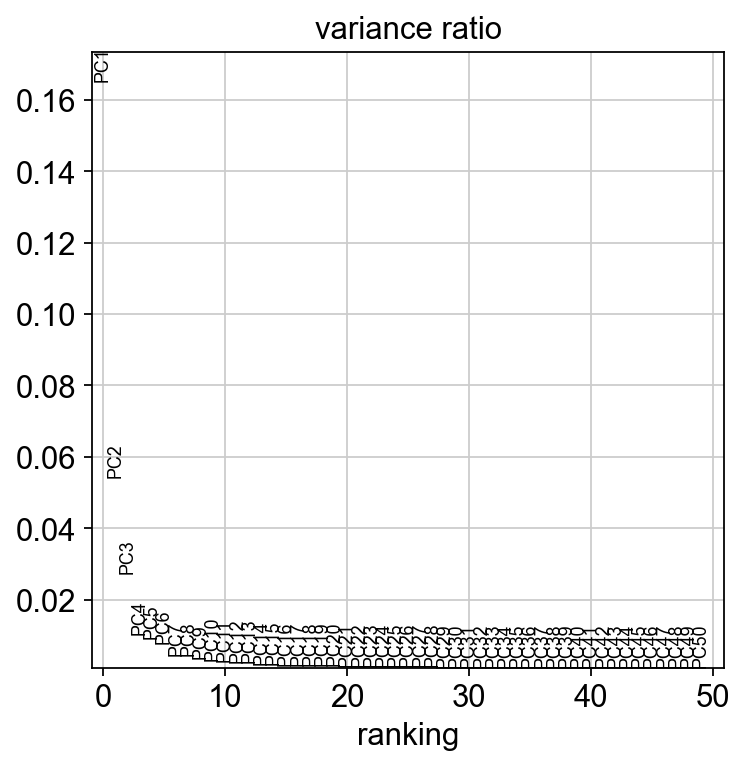

In [8]:
adata = preprocess(adata)

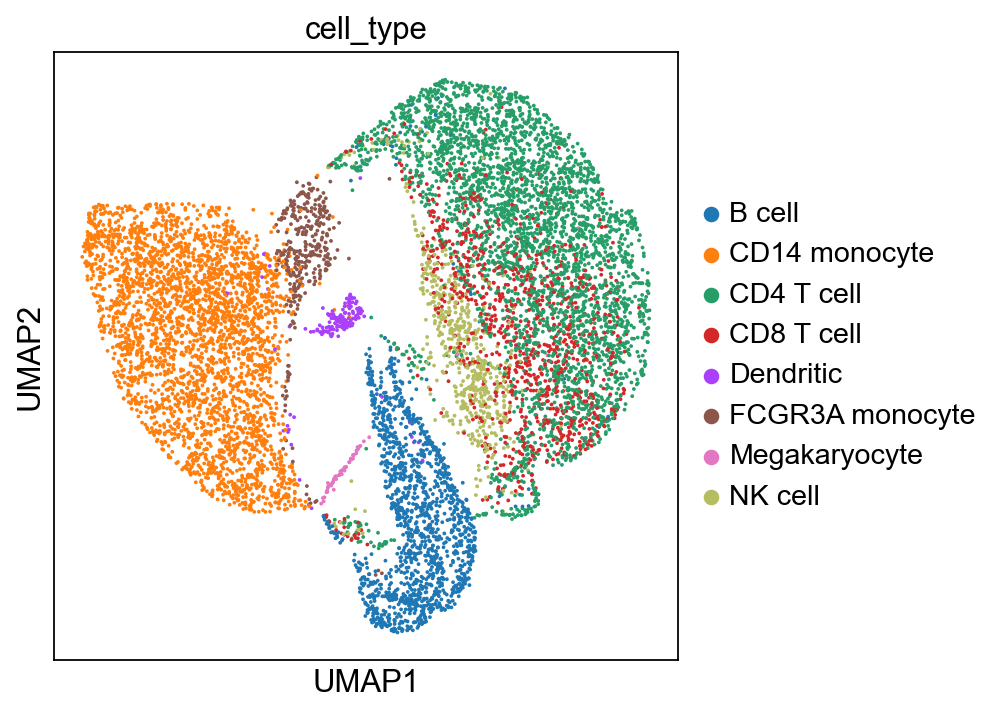

In [9]:
KNN(adata,n_pcs=10)

In [ ]:
reference_cat = ['B cell','NK cell','CD8 T cell']
infer_cnvs(adata,reference_key='cell_type',reference_cat=reference_cat)

 58%|█████▊    | 60/104 [05:33<01:21,  1.85s/it] 

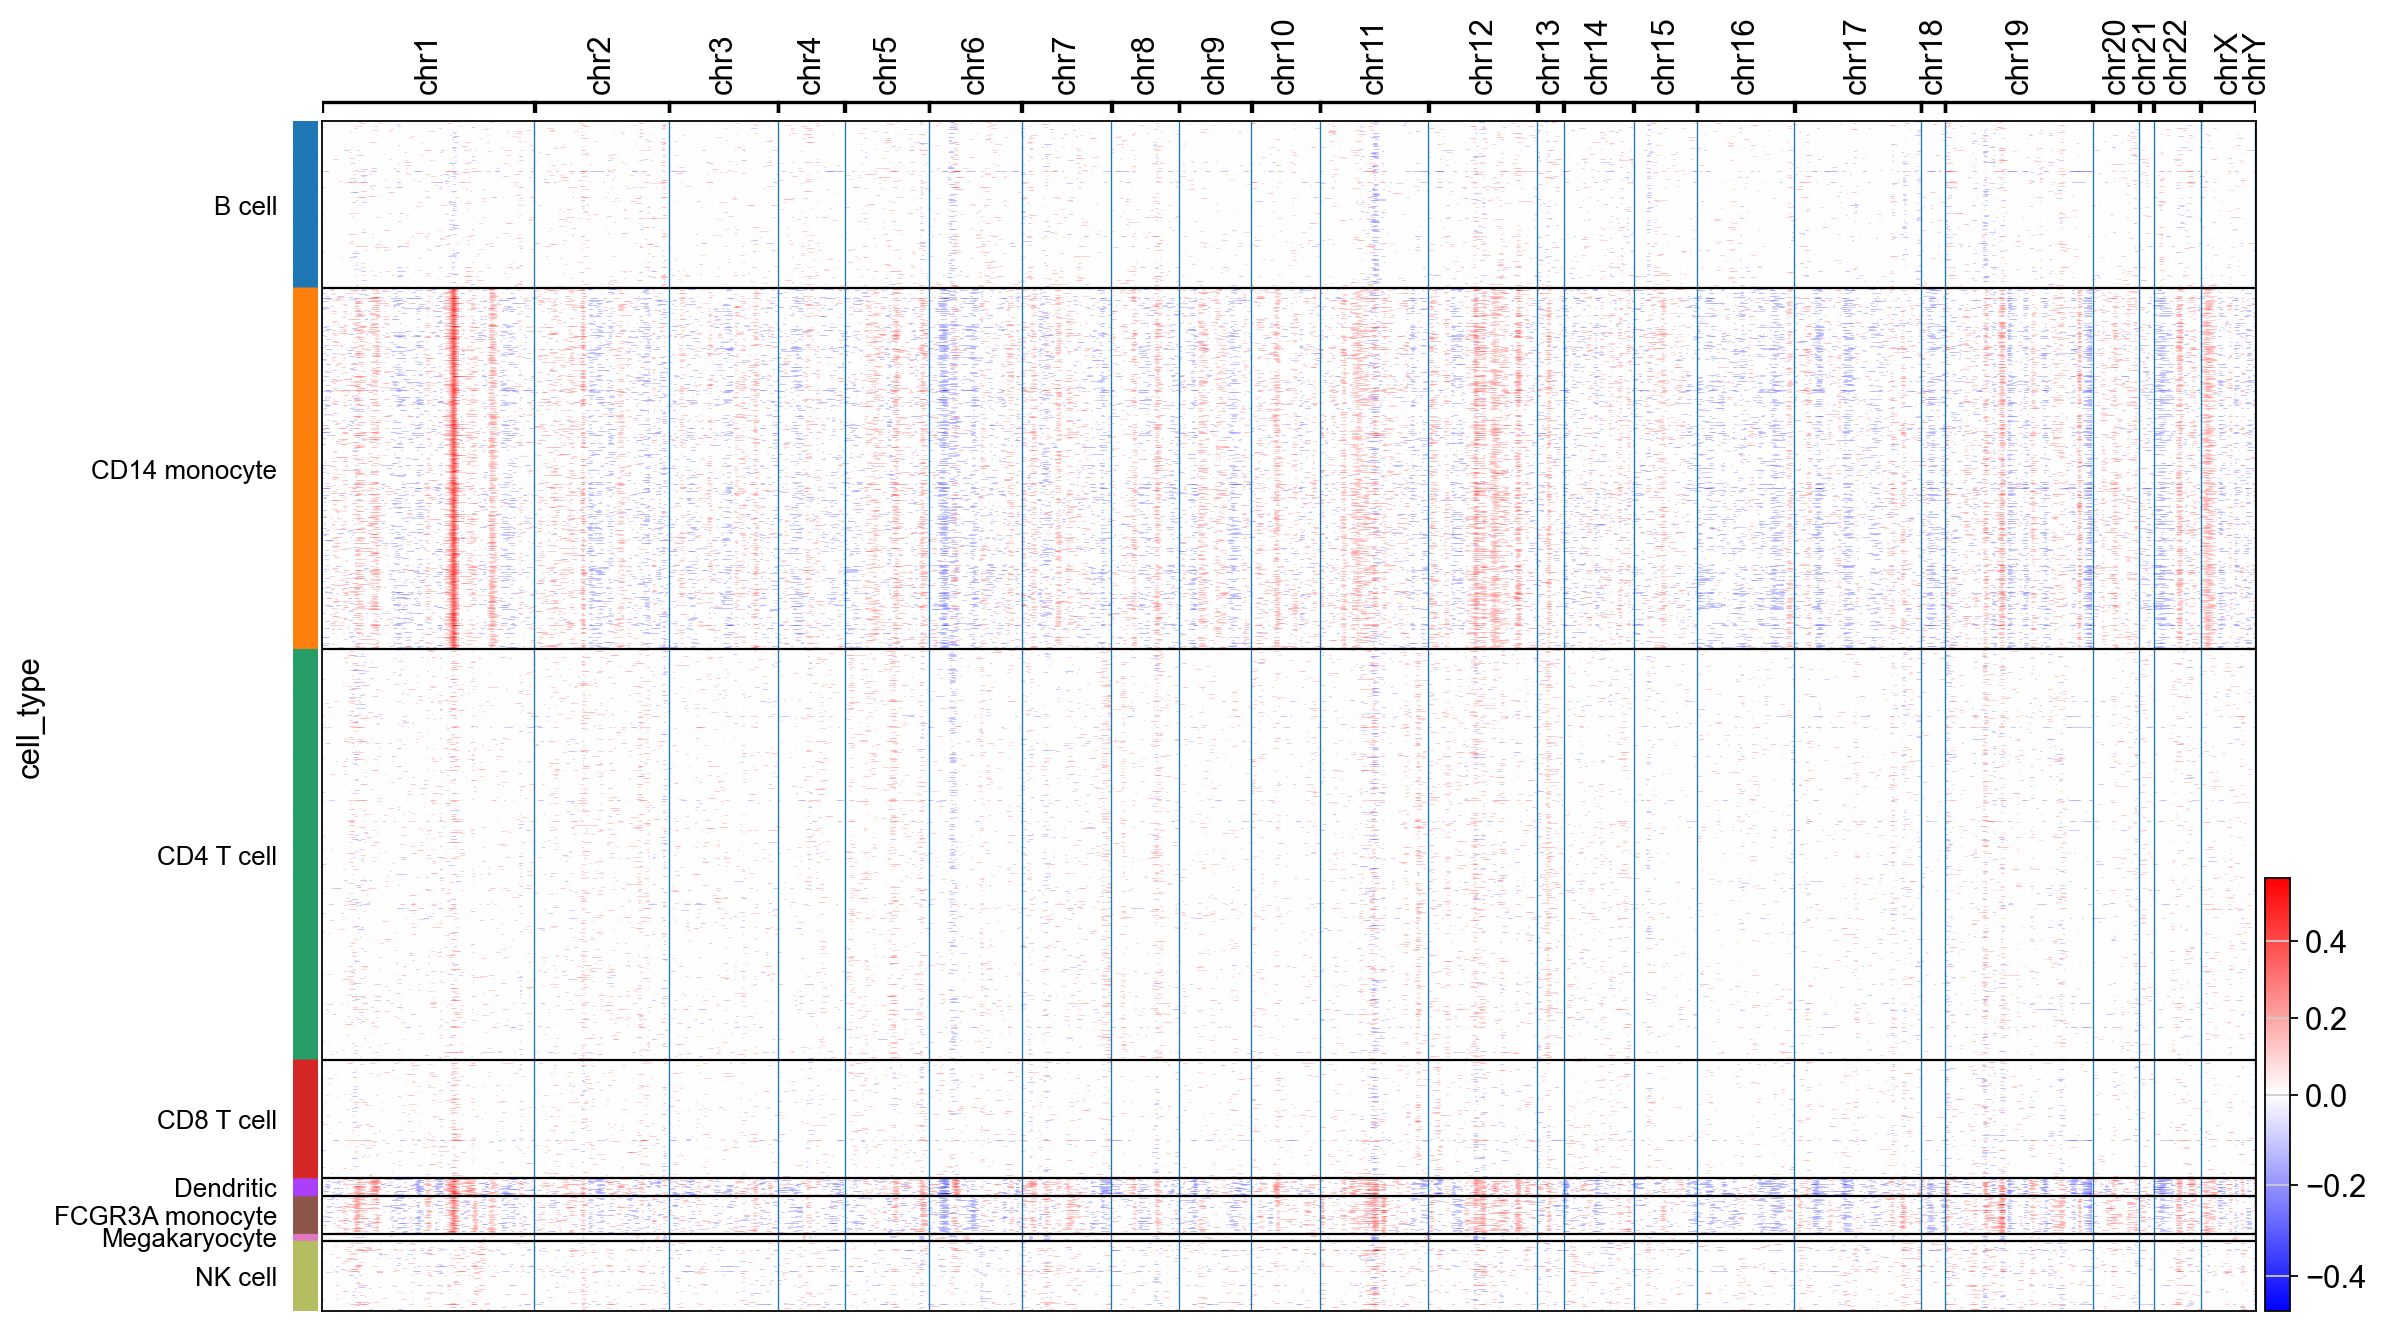

ValueError: Incompatible observations. Dendrogram data has 16 categories but current groupby observation ['cnv_leiden'] contains 13 categories. Most likely the underlying groupby observation changed after the initial computation of `sc.tl.dendrogram`. Please run `sc.tl.dendrogram` again.'

In [ ]:
cnv_plots(adata,annotation='cell_type')

# You can observe that CD14 monocytes have significant decrease in expression of genes on chr6 and chr22
# (more blue/less red than genes on other chromosomes with enough genes for comparison)
# which is expected given the simulated chr6 and chr22 loss CNAs in CD14 monocytes

# The simulated CNA chrX gain is harder to see on the heatmap
# But if you zoom in you can see not many genes in blue
# which may indicate higher expression of genes on chrX

# Actual simulated CNVs:
# - CD14 monocytes: Chr6 loss, Chr22 loss
# - CD4 T cells: ChrX gain

In [ ]:
# Possible CNV clusters
CNV_clusters = [0,1,2,11,12]

In [ ]:
# Simulated CNV information in dataset
# chr#:genomic range (CN #))
# CN 0: complete deletion
# CN 1: partial deletion
# CN 4: gain
np.unique(list(adata.obs['simulated_cnvs']))

array(['', '22:19807132-29743868 (CN 0)',
       '22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)',
       '6:25435484-35035259 (CN 1)', 'X:106533974-112956833 (CN 4)'],
      dtype='<U55')

categories: 0, 1, 2, etc.
var_group_labels: 0


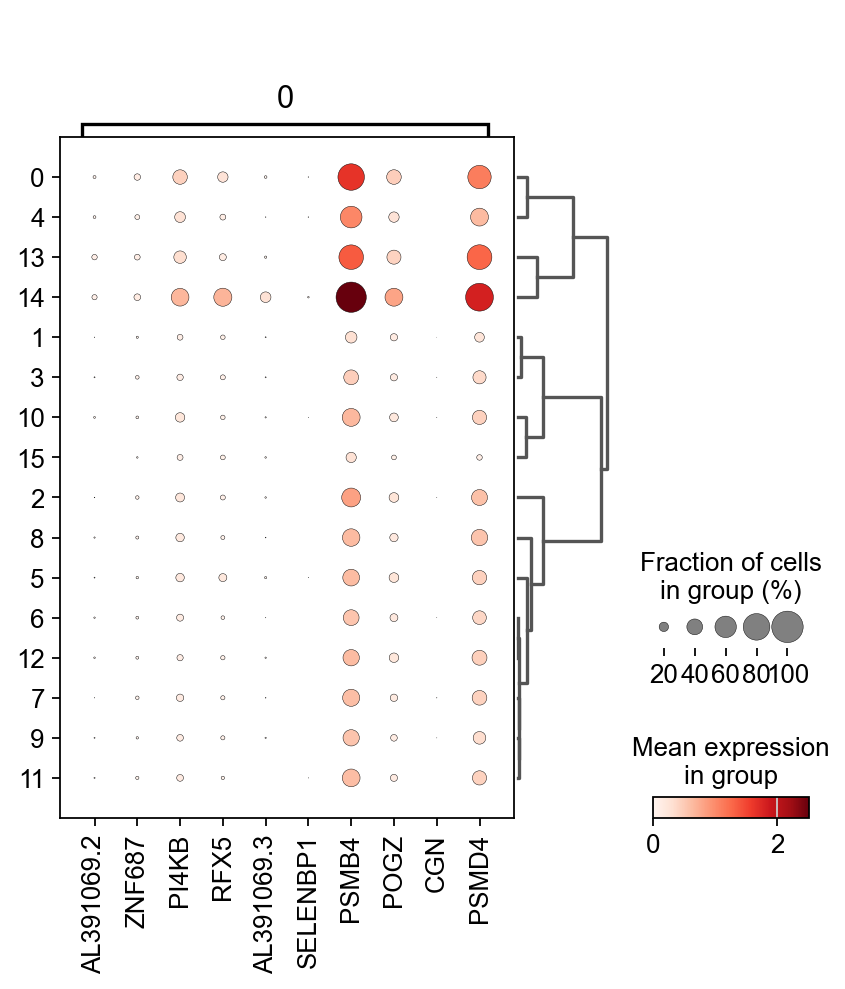

categories: 0, 1, 2, etc.
var_group_labels: 1


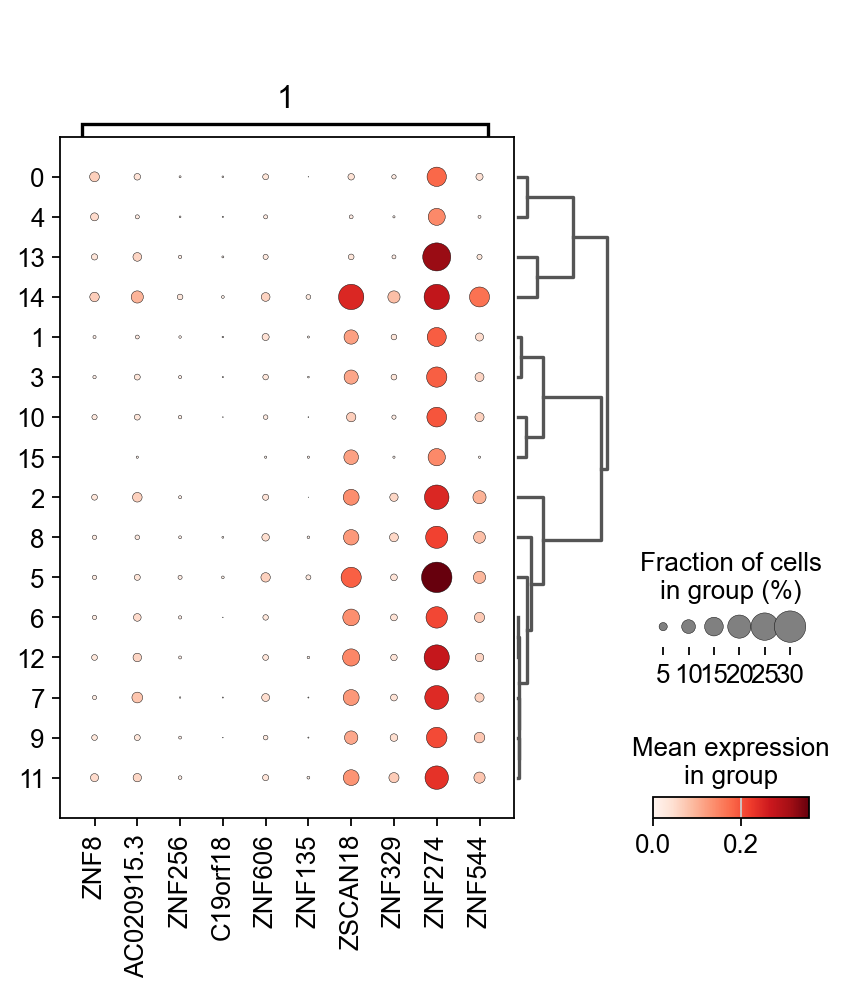

categories: 0, 1, 2, etc.
var_group_labels: 2


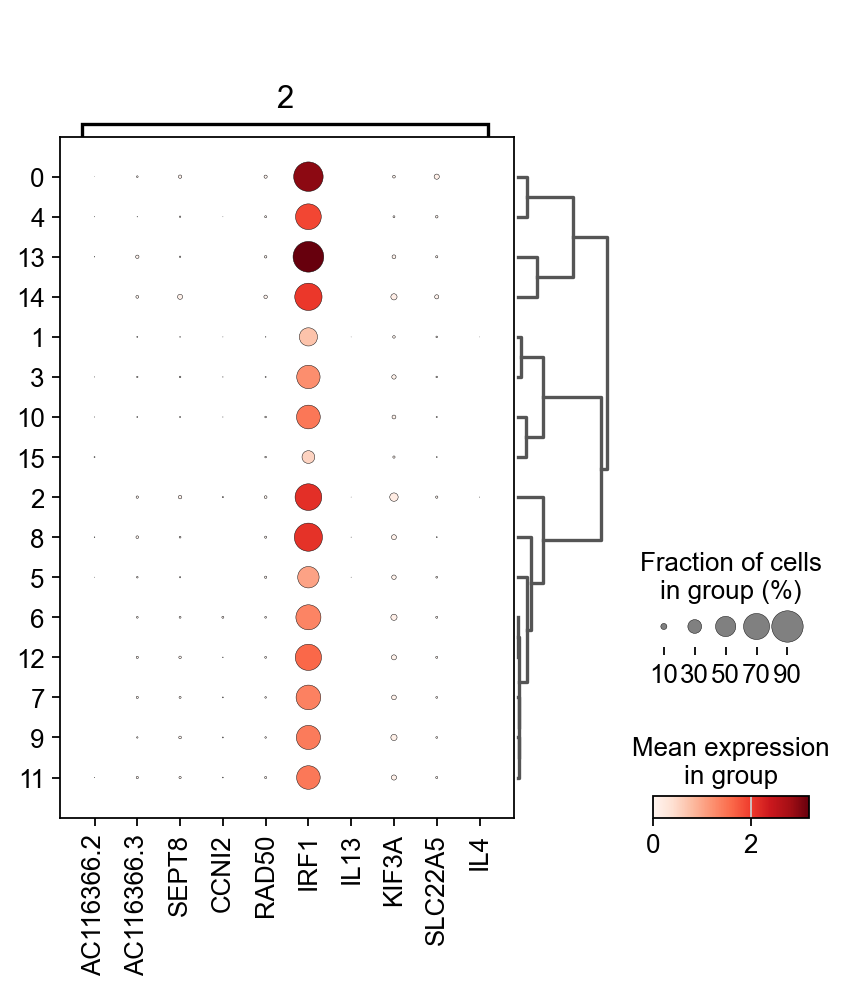

categories: 0, 1, 2, etc.
var_group_labels: 11


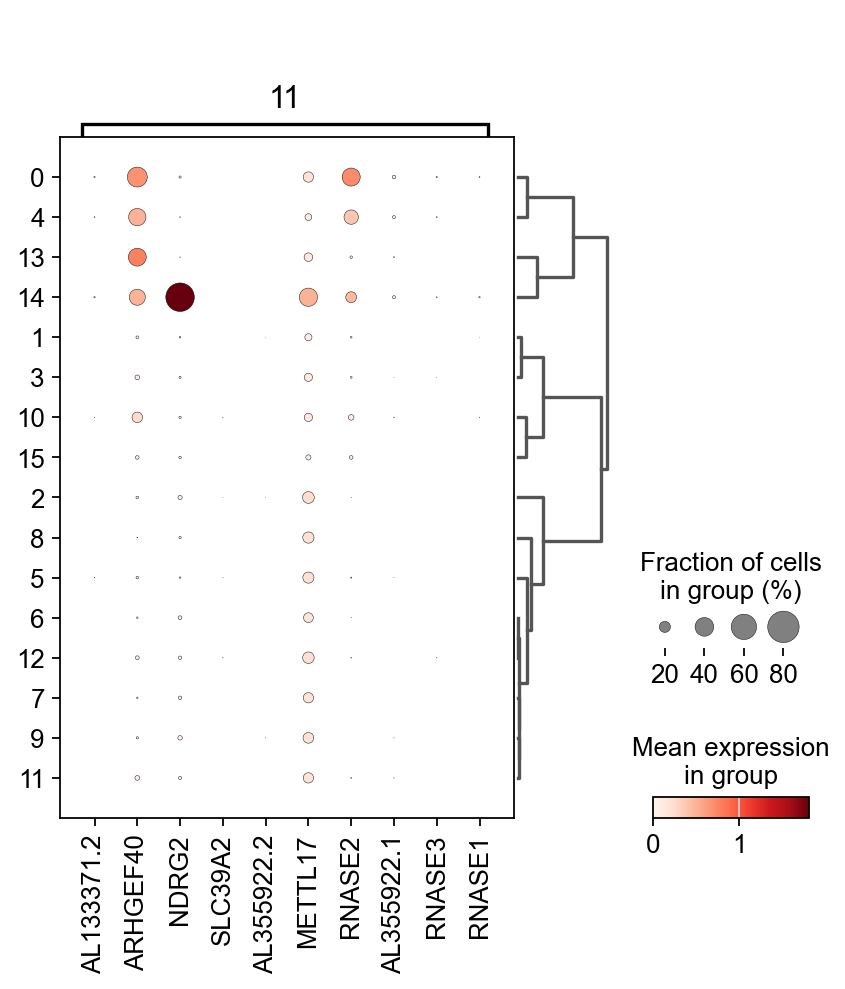

categories: 0, 1, 2, etc.
var_group_labels: 12


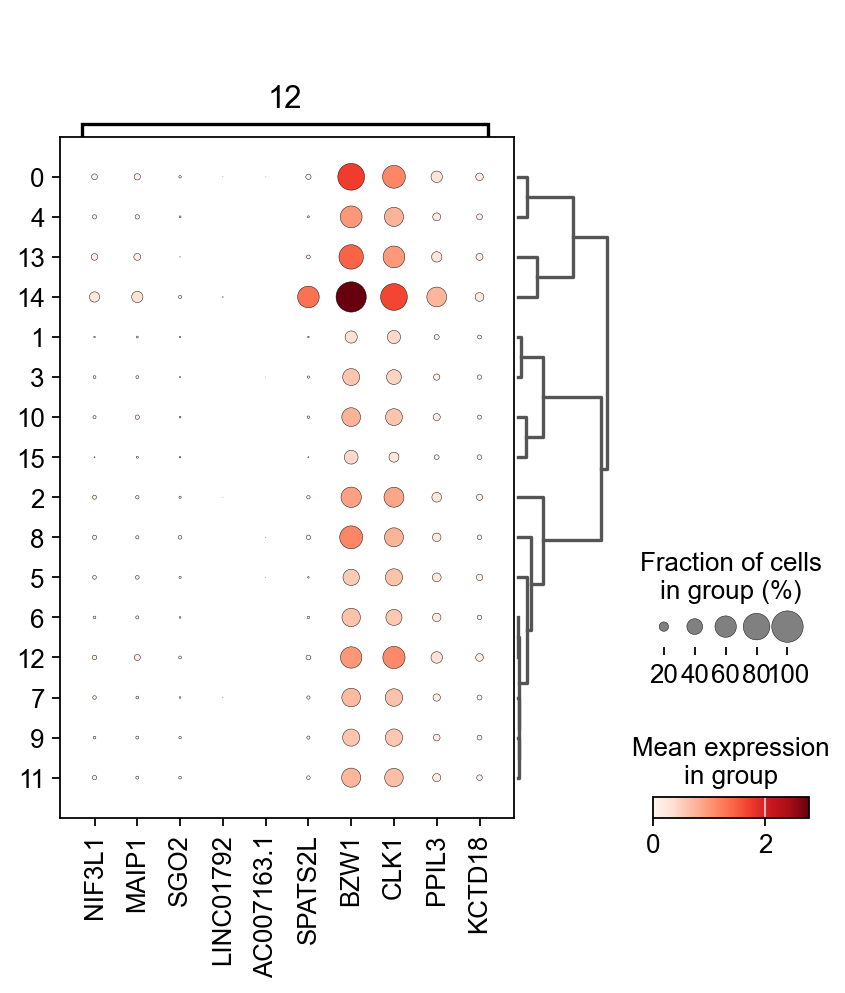

In [ ]:
CNV_ttest(adata,CNV_clusters,plot=True)

In [ ]:
adata1 = annotate_cnv(adata,CNV_clusters)

In [ ]:
adata_simonly = adata1[adata.obs['simulated_cnvs']!='']
adata_simonly.obs[adata_simonly.obs['annotated_cnvs']!='']

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,n_genes,n_counts,cell_type,simulated_cnvs,cnv_leiden,cnv_score,annotated_cnvs
AAACGCTAGGTTAAAC-1,3111,9145.0,2337.0,18.713966,1006.0,8.055733,3111,9145.0,CD14 monocyte,22:19807132-29743868 (CN 0),0,0.025252,chr1:150487414.0-155033781.0 (gain)
AAACGCTCAGTCTTCC-1,2274,4972.0,4068.0,41.045303,871.0,8.788216,2274,4972.0,CD4 T cell,X:106533974-112956833 (CN 4),2,0.008759,chr5:127045235.0-134401921.0 (gain)
AAACGCTCATAGTCAC-1,1798,3699.0,3346.0,43.945362,569.0,7.473076,1798,3699.0,CD4 T cell,X:106533974-112956833 (CN 4),11,0.004236,chr14:20425852.0-21090248.0 (loss)
AAACGCTGTCGATTTG-1,1070,1862.0,951.0,29.858711,372.0,11.679749,1070,1862.0,CD4 T cell,X:106533974-112956833 (CN 4),1,0.002270,chr19:56507850.0-58512413.0 (loss)
AAACGCTGTCTACATG-1,3311,10936.0,2972.0,19.857019,1059.0,7.075566,3311,10936.0,CD14 monocyte,"22:19807132-29743868 (CN 0), 6:25435484-350352...",0,0.025252,chr1:150487414.0-155033781.0 (gain)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGGATTCCT-1,3643,11325.0,2397.0,15.812388,1437.0,9.479518,3643,11325.0,CD14 monocyte,22:19807132-29743868 (CN 0),0,0.025252,chr1:150487414.0-155033781.0 (gain)
TTTGGTTGTTCAATCG-1,1722,3579.0,3067.0,41.904633,673.0,9.195245,1722,3579.0,CD4 T cell,X:106533974-112956833 (CN 4),2,0.008759,chr5:127045235.0-134401921.0 (gain)
TTTGTTGCAATAGGGC-1,1839,3748.0,2061.0,32.755882,483.0,7.676414,1839,3748.0,CD4 T cell,X:106533974-112956833 (CN 4),12,0.004717,chr2:197515571.0-201357398.0 (gain)
TTTGTTGGTCGGTGAA-1,3015,8283.0,1803.0,16.473276,859.0,7.848333,3015,8283.0,CD14 monocyte,22:19807132-29743868 (CN 0),0,0.025252,chr1:150487414.0-155033781.0 (gain)


In [ ]:
adata1.obs[adata1.obs['annotated_cnvs']!='']

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,n_genes,n_counts,cell_type,simulated_cnvs,cnv_leiden,cnv_score,annotated_cnvs
AAACCCACAGGTATGG-1,2122,4354.0,742.0,13.417721,434.0,7.848101,2122,4354.0,NK cell,,2,0.008759,chr5:127045235.0-134401921.0 (gain)
AAACCCACATAGTCAC-1,1521,2819.0,1734.0,33.960049,553.0,10.830396,1521,2819.0,B cell,,1,0.002270,chr19:56507850.0-58512413.0 (loss)
AAACCCAGTGGCTACC-1,1869,3879.0,2399.0,35.795288,424.0,6.326470,1869,3879.0,CD4 T cell,,2,0.008759,chr5:127045235.0-134401921.0 (gain)
AAACCCATCCCGAGAC-1,1866,4015.0,2532.0,35.702198,545.0,7.684715,1866,4015.0,CD4 T cell,,2,0.008759,chr5:127045235.0-134401921.0 (gain)
AAACGAAAGGAGTCTG-1,3382,9202.0,1769.0,14.602939,1143.0,9.435364,3382,9202.0,CD14 monocyte,,0,0.025252,chr1:150487414.0-155033781.0 (gain)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTGCCGAC-1,1817,3961.0,3154.0,41.030312,572.0,7.441135,1817,3961.0,CD4 T cell,,2,0.008759,chr5:127045235.0-134401921.0 (gain)
TTTGTTGCAATAGGGC-1,1839,3748.0,2061.0,32.755882,483.0,7.676414,1839,3748.0,CD4 T cell,X:106533974-112956833 (CN 4),12,0.004717,chr2:197515571.0-201357398.0 (gain)
TTTGTTGGTCGGTGAA-1,3015,8283.0,1803.0,16.473276,859.0,7.848333,3015,8283.0,CD14 monocyte,22:19807132-29743868 (CN 0),0,0.025252,chr1:150487414.0-155033781.0 (gain)
TTTGTTGGTCTGTAAC-1,1738,3506.0,1749.0,29.709530,632.0,10.735519,1738,3506.0,CD8 T cell,,11,0.004236,chr14:20425852.0-21090248.0 (loss)
